In [1]:
import numpy as np
import random
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

num_drones = 8
drone_id = 0
population = []

In [2]:
class Drone:
    id = 0
    x = 0
    y = 0
    coverage = 3
    rely_on = None
    send_to = None
    connected_to = []
    
    def __init__(self):
        global drone_id
        self.id = drone_id
        drone_id += 1
        self.connected_to = []
        self.rely_on = None
        self.send_to = None
        
    def __repr__(self):
        return str(self.id)
        

In [3]:
def vertices_of_regpoly(n, r):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        x.append((the_map.size / 2) + r * math.cos(2 * math.pi * i / n))
        y.append((the_map.size / 2) + r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [4]:
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 2)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]

In [5]:
class Swarm:
    drones = []
    connectedness = []
    
    def __init__(self, drones):
        self.drones = drones
        global drone_id
        drone_id = 0
        set_init_drones(self)
        self.assign_connectedness()
        self.assign_drone_connect()
        self.rssi_table = []
    
    def assign_connectedness(self):
        #Make the swarm's connectivity matrix
        #This matrix is really only used for initial configuration
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))

        #The upper traingle of a mtrix w/o diagonal is filled in with 1s
        #the diagonal would mean drones are connected to themselves
        #the lower triangle is just a reflection
        #representation of the connections between drones
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[j][i] = 1

        # Ensure that each drone has at least one connection
        for i in range(0,len(self.drones)):
            possible_values = np.nonzero(self.connectedness[i])[0].tolist()
            choice = random.choice(possible_values) if possible_values else -1
            if choice != -1:
                possible_values.remove(choice)
            #Remaining choices have a possibility of not being connections (probability related to the number of drones)
            for value in possible_values:
                self.connectedness[i][value] = 0 if random.random() > 1.0/float(len(self.drones)) else 1

        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[i][j] = self.connectedness[j][i]
    
    def assign_drone_connect(self):
        #Assign list connectedness in drones
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for i in range(0,len(self.connectedness)):
            for j in range(0, len(self.connectedness)):
                if self.connectedness[i][j] == 1:
                    self.drones[i].connected_to.append(self.drones[j])

In [6]:
def determine_architecture(swarm):
    coordinator = None
    for drone in swarm.drones:
        if coordinator == None:
            coordinator = drone
            rssi = 0
        else:
            rssi = drone_sig_strength(drone_distance(drone, coordinator))
        init_rssi_table(drone, rssi, swarm.rssi_table)
    sort_table_by_rssi(swarm.rssi_table)

In [7]:
def init_rssi_table(node_check, rssi, rssi_table):
    node = {}
    node["node"] = node_check
    node["rssi"] = rssi
    rssi_table.append(node)

In [8]:
def sort_table_by_rssi(rssi_table):
    rssi_table.sort(key=lambda val: val["rssi"])

In [9]:
def determine_neighbors(swarm):
    for index in range(0, len(swarm.rssi_table)):
        node = swarm.rssi_table[index]['node']
        if index == 0:
            node.rely_on = None
            node.send_to = swarm.rssi_table[index + 1]['node']
        elif index == len(swarm.rssi_table) - 1:
            node.rely_on = swarm.rssi_table[index - 1]['node']
            node.send_to = None
        else:
            node.rely_on = swarm.rssi_table[index - 1]['node']
            node.send_to = swarm.rssi_table[index + 1]['node']

In [10]:
def create_starting_population(size):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member(num_drones))
        
    return population

In [11]:
def create_new_member(num_drones):
    drones = []
    for i in range(0, num_drones):
        drones.append(Drone())
    member = Swarm(drones)
    return member

In [12]:
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        
        circle1 = plt.Circle((drone.x, drone.y), drone.coverage, color = 'b', fill=False)        
        ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    # Draws a visualization for the network connections    
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [13]:
def draw_scene(swarm):
    plot_swarm(swarm)
    the_map.draw_map()

In [14]:
class GeoMap:
    search_points = []
    def __init__(self, size):
        self.size = size
        self.populate_search_points()
        
    def draw_map(self):
        plt.plot([0,0, self.size, self.size, 0], 
                 [0, self.size, self.size,0, 0])
        self.disp_search_points()
        
    def disp_search_points(self):
        for x in range(0, len(the_map.search_points)):
            for y in range(0, len(the_map.search_points[x])):
                if the_map.search_points[x][y]:
                    plt.plot(x, y, '.', color='green')
        
    def populate_search_points(self):
        for i in range(0, self.size + 2):
            row = []
            for j in range(0, self.size + 2):
                row.append(False)
            self.search_points.append(row)

In [15]:
def drone_distance(drone1, drone2):
    return math.hypot(drone2.x - drone1.x, drone2.y - drone1.y)

def drone_sig_strength(drone_dist):
    #return 20*math.log10(1/math.pow(drone_dist,2))
    #return 1/math.pow(drone_dist,2)
    return  10*2*math.log10(drone_dist) + 1

def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , drone_sig_strength(dist)])
    return swarm_strength

In [16]:
def check_drone_coverage(swarm):
    #Only check the points that are within the area that drones are searching
    global the_map
    min_x = the_map.size + 1
    max_x = 0
    min_y = the_map.size + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
            
    #Check if points are within drone coverage
    for x in range(int(min_x - drone.coverage), int(max_x + drone.coverage) + 1):
        for y in range(int(min_y - drone.coverage), int(max_y + drone.coverage) + 1):
            for drone in swarm.drones:
                dist = math.sqrt(math.pow(x-drone.x, 2) + math.pow(y-drone.y, 2))
                if dist <= drone.coverage:
                    if x >= 0 and x < the_map.size and y >= 0 and y < the_map.size:
                        the_map.search_points[x][y] = True

    #print(swarm_sig_strength(swarm))
    #print(the_map.search_points)
        

In [17]:
def init():
    global population
    population = create_starting_population(1)
    for swarm in population:
        plot_swarm(swarm)
        check_drone_coverage(swarm)
        the_map.draw_map() 
        
    for swarm in population:
        determine_architecture(swarm)
        determine_neighbors(swarm)
        
        

In [18]:
def scatter():
    for swarm in population:
        for drone in swarm.drones:
            for i in range(0, 1000):
                drone.x += random.random() - .5
                drone.y += random.random() - .5
                check_drone_coverage(swarm)
        draw_scene(swarm)
        

        #print(swarm_sig_strength(swarm))

In [19]:
the_map = GeoMap(50)

In [20]:
def equalize_map():
    plt.xlim(-the_map.size*.05, the_map.size + the_map.size*.05)
    plt.ylim(-the_map.size*.05, the_map.size + the_map.size*.05)
    plt.gca().set_aspect('equal', adjustable='box')

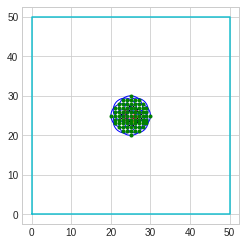

In [21]:
init()

equalize_map()

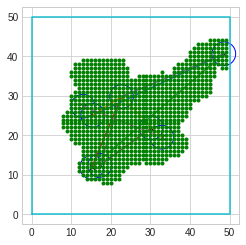

In [22]:
scatter()
equalize_map()

In [23]:
#https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    return 2*((1.0/(1+ np.exp(-1*x)))-0.5)

class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        print(self.input)
        self.weights1   = np.random.rand(self.input.shape[1], 3)
        print(self.weights1)
        self.weights2   = np.random.rand(3, 2)  
        print(self.weights2)
        
        self.output = np.zeros(y.shape)
        
    def feedforward(self):
        #For simplicity, biases are assumed to be zero
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        print(self.layer1)
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
        print(self.output)

In [24]:
x = [-1 , 4 , -2, 30, -90]
y = np.array([[0],[0],[0],[0]])
input = np.array([x])
nn = NeuralNetwork(input, y)


[[ -1   4  -2  30 -90]]
[[0.03989961 0.85762421 0.06636276]
 [0.86665994 0.66742744 0.93016276]
 [0.70570525 0.05006887 0.15284929]
 [0.32835711 0.41639971 0.87950501]
 [0.11637537 0.84468169 0.41216366]]
[[0.43665745 0.36915824]
 [0.03389483 0.39351439]
 [0.99387736 0.87438385]]


In [25]:
nn.feedforward()

[[ 0.6019055  -1.         -0.99872967]]
[[-0.36430569 -0.47946901]]
